In [37]:
import sys
from pathlib import Path

sys.path.append(str(Path("..").resolve()))
sys.path.append(str(Path("../..").resolve()))

from src.data_ingestion import *
from src.data_preprocessing import *


from pyspark.sql import DataFrame
from pyspark.sql.functions import col
from pyspark.sql.types import NumericType, StringType
from pyspark.sql import functions as F

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

import seaborn as sns

import numpy as np

from itertools import combinations

from scipy import stats

import matplotlib.pyplot as plt

import pandas as pd



In [38]:
spark = init_spark()
df = load_data(spark, "../../data/US_Accidents_March23.csv")
df.printSchema()
# df.show(5)  

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- V

In [39]:
# missing_values = check_missing_values(df)

## Cleaning Data

In [40]:
# df = cast_columns(df)
# df = drop_high_missing_columns(df)
# df = impute_missing_values(df)
# df.cache()

In [41]:
# df.describe().show()

In [42]:
# missing_values = check_missing_values(df)

## Feature Engineering 


In [43]:
from pyspark.sql.functions import col

def convert_temp_to_celsius(df, temp_col="Temperature(F)", new_col="Temperature(C)"):
    return df.withColumn(new_col, (col(temp_col) - 32) * 5 / 9)

df = convert_temp_to_celsius(df)

## Decriptive Analysis

### Weather Analysis

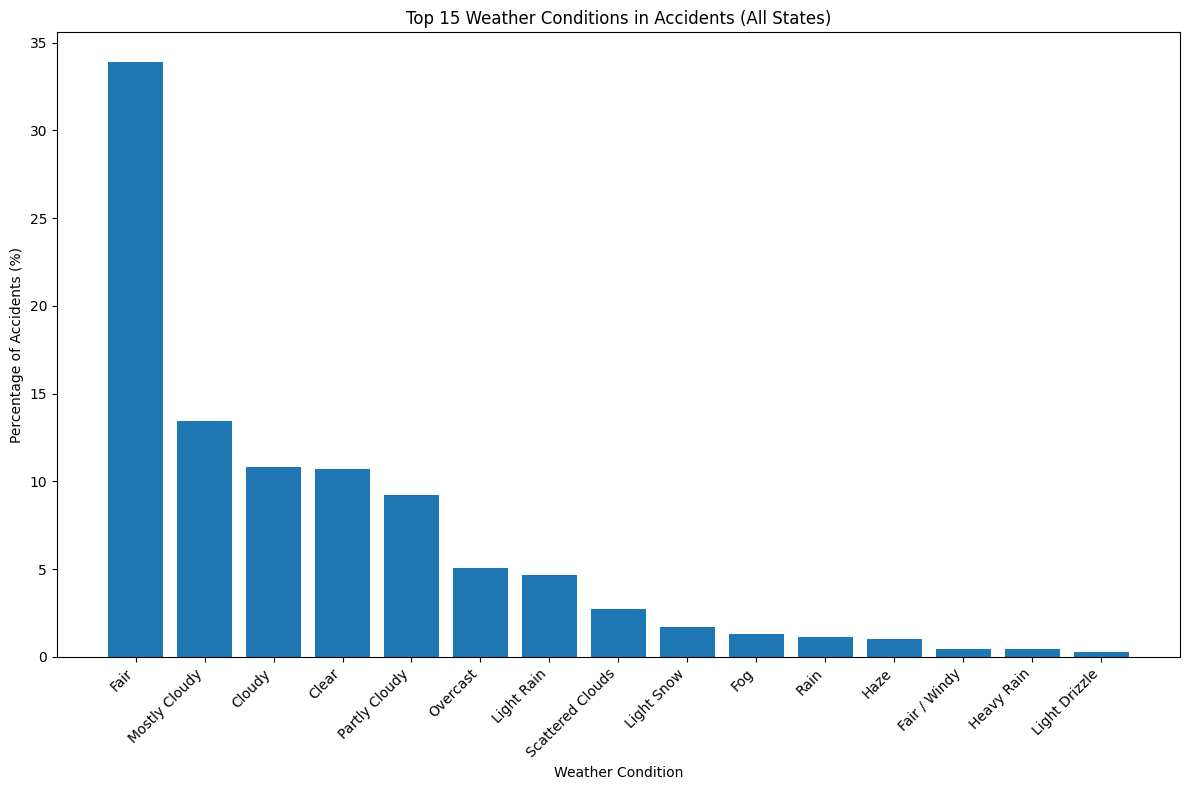

In [ ]:
weather_condition_to_consider = 15
total_accidents = df.filter(F.col("Weather_Condition").isNotNull()).count()

top_weather_df = (
    df.filter(F.col("Weather_Condition").isNotNull())
    .groupBy("Weather_Condition")
    .agg(F.count("*").alias("count"))
    .withColumn("percentage", (F.col("count") / total_accidents) * 100)
    .orderBy(F.col("count").desc())  
    .limit(weather_condition_to_consider)  
    .toPandas()  
)

plt.figure(figsize=(12, 8))
plt.bar(top_weather_df["Weather_Condition"], top_weather_df["percentage"])
plt.title(f"Top {weather_condition_to_consider} Weather Conditions in Accidents (All States)")
plt.xlabel("Weather Condition")
plt.ylabel("Percentage of Accidents (%)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()



### 🚨 Key Insights:

1. **Fair weather dominates accident scenes**:
   - **~34%** of all accidents occurred under *"Fair"* conditions — implying that good visibility and dry roads don't prevent accidents.
   - This suggests **driver behavior** (distraction, speeding) may be a more critical factor than weather in many cases.

2. **Cloud-related conditions contribute significantly**:
   - Combined conditions like *"Mostly Cloudy"*, *"Cloudy"*, *"Partly Cloudy"*, and *"Overcast"* account for **~39%** of accidents.
   - Overcast skies might reduce visibility or affect driver alertness, but aren't as severe as storms.

3. **Rain & snow are less dominant but still relevant**:
   - *"Light Rain"*, *"Rain"*, *"Heavy Rain"*, *"Light Snow"*, and *"Light Drizzle"* collectively contribute **~11%**.
   - Though dangerous, these conditions likely cause drivers to be more cautious, reducing total accident count despite higher risk per mile.

4. **Rare conditions still matter**:
   - Categories like *"Fog"*, *"Haze"*, and *"Scattered Clouds"* represent smaller shares, but could be disproportionately dangerous — worth investigating in severity analysis.

---


In [ ]:
aggregated_temperatures = df.groupBy("State").agg(F.avg("Temperature(F)").alias("avg_temperature"))
result = aggregated_temperatures.collect()  # Collect aggregated results  

avg_temperatures = [row['avg_temperature'] for row in result]

plt.figure(figsize=(15, 10))

sns.histplot(avg_temperatures, kde=True, bins=30, stat='density')

plt.title('Distribution of Average Temperature during Accidents (All States)')
plt.xlabel('Temperature (F)')
plt.ylabel('Density')
plt.tight_layout()

plt.show()

In [ ]:
# Bucket temperatures
df = df.withColumn(
    "Temperature_Bucket",
    F.when(col("Temperature(C)") < 0, "Freezing (<0°C)")
    .F.when((col("Temperature(C)") >= 0) & (col("Temperature(C)") < 10), "Cold (0–10°C)")
    .F.when((col("Temperature(C)") >= 10) & (col("Temperature(C)") < 20), "Cool (10–20°C)")
    .F.when((col("Temperature(C)") >= 20) & (col("Temperature(C)") < 30), "Mild (20–30°C)")
    .F.when((col("Temperature(C)") >= 30) & (col("Temperature(C)") < 40), "Hot (30–40°C)")
    .otherwise("Extreme (40°C+)")
)

severity_dist = df.groupBy("Temperature_Bucket", "Severity").count().toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=severity_dist, x="Temperature_Bucket", y="count", hue="Severity")
plt.title("Severity Distribution Across Temperature Buckets")
plt.xlabel("Temperature Bucket")
plt.ylabel("Number of Accidents")
plt.tight_layout()

plt.show()


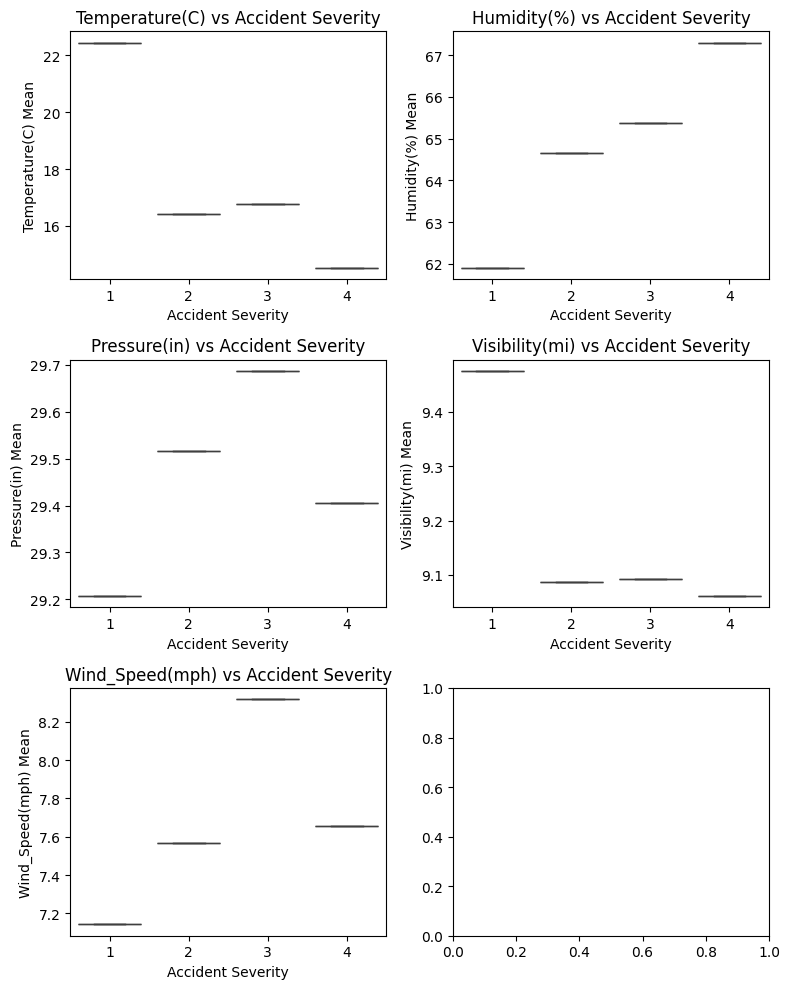

In [ ]:
# List of weather factors
weather_factors = ['Temperature(C)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)']

fig, axes = plt.subplots(3, 2, figsize=(8, 10))
axes = axes.flatten()

for i, factor in enumerate(weather_factors):
    factor_data = df.groupBy("Severity").agg(
        F.mean(factor).alias(f"{factor}_mean"),
        F.min(factor).alias(f"{factor}_min"),
        F.max(factor).alias(f"{factor}_max"),
        F.stddev(factor).alias(f"{factor}_stddev")
    )
    
    factor_data_pd = factor_data.toPandas()
    
    sns.boxplot(x='Severity', y=f'{factor}_mean', data=factor_data_pd, ax=axes[i])
    axes[i].set_title(f'{factor} vs Accident Severity')
    axes[i].set_xlabel('Accident Severity')
    axes[i].set_ylabel(f'{factor} Mean')

plt.tight_layout()

plt.show()

### 🌡️ Weather's Whisper on Accident Severity:

1.  **Cooler Temperatures, Higher Stakes?**:
    - The data suggests that accidents occurring at **lower temperatures** tend to be associated with **greater severity**.
    - Could icy conditions or other cold-weather hazards be playing a significant role in the seriousness of these incidents?

2.  **Humidity's Heavy Hand**:
    - Accidents happening with **higher humidity levels** appear to correlate with **increased severity**.
    - Perhaps rain or other moisture-related factors contribute to more impactful collisions.

3.  **Pressure's Subtle Story**:
    - The relationship between **air pressure** and accident severity seems less pronounced, showing only minor fluctuations across the severity levels.
    - This might indicate that pressure itself is not a primary driver of severity, or its influence is more complex.

4.  **Visibility's Vital Role**:
    - **Lower visibility** is strongly linked to **more severe accidents**.
    - This underscores the critical impact of clear sight on road safety and the potential dangers of driving in compromised visual conditions.

In [ ]:
# Define weather-related features
weather_features = [
    'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 
    'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)'
]

df = df.dropna(subset=weather_features)

assembler = VectorAssembler(inputCols=weather_features, outputCol="features_raw")
df = assembler.transform(df)

scaler = StandardScaler(inputCol="features_raw", outputCol="features_scaled", withStd=True, withMean=True)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

kmeans = KMeans(featuresCol="features_scaled", k=4, seed=42)
model = kmeans.fit(df)

clustered_df = model.transform(df)

clustered_df.select("features_scaled", "prediction").show(5)

+--------------------+----------+
|     features_scaled|prediction|
+--------------------+----------+
|[-1.2203062221538...|         1|
|[-1.2463250589988...|         1|
|[-1.2463250589988...|         1|
|[-1.2463250589988...|         1|
|[-1.4336606842832...|         1|
+--------------------+----------+
only showing top 5 rows



In [49]:
clustered_df.groupBy("prediction").agg(*[F.avg(col).alias(f"avg_{col}") for col in weather_features]).show()

clustered_df.groupBy("prediction").agg(F.avg("Severity").alias("avg_severity")).show()


+----------+------------------+------------------+------------------+-----------------+------------------+-------------------+---------------------+
|prediction|avg_Temperature(F)| avg_Wind_Chill(F)|   avg_Humidity(%)| avg_Pressure(in)|avg_Visibility(mi)|avg_Wind_Speed(mph)|avg_Precipitation(in)|
+----------+------------------+------------------+------------------+-----------------+------------------+-------------------+---------------------+
|         1| 44.14621015931413| 41.03849524061764| 79.07526353383055|29.54247937822547| 7.709724402182004|  6.534608279592046| 0.013799110450290173|
|         0|  73.6110664652578| 73.58784608589653| 56.82323224123472|29.59112301127222| 9.849646241161164|   7.85224625116755| 0.001389273884362...|
|         3|              45.5|42.333333333333336|              85.0|            29.55| 8.666666666666666|                5.5|                26.24|
|         2| 49.05709553664015|46.148671178516075|52.960177493761705|25.43199856363438|  9.19773156816691|

In [50]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(featuresCol='features_scaled', metricName='silhouette', distanceMeasure='squaredEuclidean')
silhouette = evaluator.evaluate(clustered_df)
print(f"Silhouette Score = {silhouette}")


Silhouette Score = 0.4125639424648403
